# TASK 1: Initial data loading and clearning in python and Data importing in PostgreSQL server 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [2]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json

In [3]:
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
from shapely.wkt import loads
import geopandas as gpd

### The below two functions are used to connect the python with PostgreSQL so that we can access database in SQL server.

In [4]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [127]:
db, conn = pgconnect(credentials)

Connected successfully.


In [6]:
conn.execute(text("""CREATE EXTENSION IF NOT EXISTS postgis;"""))

In [7]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


# The below is the SA2 dataset

The xml file storing the metadata is loaded to have a look.

In [8]:
with open('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.xml', 'r') as f_SA2:
    data_SA2 = f_SA2.read()
SA2_data = BeautifulSoup(data_SA2, "lxml")
SA2_data

<?xml version="1.0" encoding="UTF-8"?><!-- edited with XMLSpy v2020 rel. 2 sp1 (x64) (http://www.altova.com) by  (Australian Bureau of Statistics) --><!-- UNCLASSIFIED --><!-- Built from ANZLIC MET Template ISO 19139 2009-02-18 --><html><body><gmd:md_metadata xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gml="http://www.opengis.net/gml" xmlns:gts="http://www.isotc211.org/2005/gts" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemalocation="http://www.isotc211.org/2005/gmd http://www.isotc211.org/2005/gmd/gmd.xsd http://www.opengis.net/gml http://www.isotc211.org/2005/gml/gml.xsd http://www.w3.org/1999/xlink http://www.isotc211.org/2005/xlink/xlinks.xsd">
<gmd:fileidentifier>
<gco:characterstring>ABS-ASGS-ED3-SA2-2021-7844</gco:characterstring>
</gmd:fileidentifier>
<gmd:language>
<gco:characterstring>eng</gco:characterstring>
</gmd:language>
<gmd:characterset>
<gmd:md_characterset

In [9]:
GDA2020 = 7844
GDA94 = 4283
# defined the SRID

### The read_file function in the Geopandas libary is used to read the shapefile containing the Spatial Data

In [10]:
f_sa2 = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
f_sa2

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,901031003,Jervis Bay,0,No change,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,67.2296,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556..."
2469,901041004,Norfolk Island,0,No change,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,38.6510,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((167.96325 -29.07212, 167.96326..."
2470,997979799,Migratory - Offshore - Shipping (OT),0,No change,99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None
2471,999999499,No usual address (OT),0,No change,99999,No usual address (OT),999,No usual address (OT),99499,No usual address (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None


In [11]:
f_sa2["geometry"].crs.name

'GDA2020'

### filter the database to the Greater Syndey ensuring our focus region

In [12]:
f_sa2 = f_sa2[f_sa2['GCC_NAME21'] == 'Greater Sydney']
f_sa2.head()

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


### By reading the database, the geometry column have both polygon geometry type and multipolygon geometry type. In order to convert the polygons into multipolygon so that the geometry type in the geometry column is consistent. 
### A function for WKT conversion is defined to enable the polygons to convert into multipolygon as shown below.

In [13]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

f_sa2co = f_sa2.copy()
f_sa2['geom'] = f_sa2co['geometry'].apply(lambda x: create_wkt_element(geom=x, srid = GDA2020))
f_sa2 = f_sa2.drop(columns="geometry")

/opt/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### As only the data about Statistical Area Level 2 is relevant to our other databases and the database is already filtered down to Greater Sydney, so the columns about the area region (such as GCC (Greater Captal City Statistical Areas), STE (States and Territories)) and other area level (such as SA3, SA3) are dropped. Thus, only three columns were considered as useful which are kept.

In [14]:
f_sa2 = f_sa2[['SA2_CODE21', 'SA2_NAME21', 'geom']]
f_sa2 = f_sa2.rename(columns={'SA2_CODE21': 'sa2_code21', 'SA2_NAME21': 'sa2_name21'})
f_sa2

,sa2_code21,sa2_name21,geom
28,102011028,Avoca Beach - Copacabana,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...
637,128021537,Royal National Park,MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,MULTIPOLYGON (((151.03954821100714 -34.0417452...


In [15]:
f_sa2 = f_sa2.dropna()

### Create the table in the SQL server and insert the information in the database into the table.

In [16]:
conn.execute(text("""
 drop table if exists sa2 CASCADE;
 create table sa2(
     sa2_code Numeric,
     sa2_name VARCHAR(100),
     geom GEOMETRY(MULTIPOLYGON, 7844)
);"""))

In [17]:
f_sa2.to_sql("sa2", conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', GDA2020)})

query(conn, "select * from sa2")

,sa2_code21,sa2_name21,geom
0,102011028,Avoca Beach - Copacabana,0106000020A41E0000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0106000020A41E00000100000001030000000100000010...
2,102011030,Calga - Kulnura,0106000020A41E00000200000001030000000100000085...
3,102011031,Erina - Green Point,0106000020A41E00000100000001030000000100000041...
4,102011032,Gosford - Springfield,0106000020A41E0000010000000103000000010000007E...
...,...,...,...
368,128021537,Royal National Park,0106000020A41E00000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0106000020A41E00000100000001030000000100000089...
370,128021607,Engadine,0106000020A41E0000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0106000020A41E000001000000010300000001000000A1...


# The below is the School dataset.

### The function read_file from the Geopandas library is used to read the shapefiles with the spatial data.
### As there are three different categories of school according to the given databases, they are read separately.

In [18]:
f_school_future = gpd.read_file("catchments/catchments_future.shp")
f_school_primary = gpd.read_file("catchments/catchments_primary.shp")
f_school_secondary = gpd.read_file("catchments/catchments_secondary.shp")

In [19]:
f_school_future["geometry"].crs.name

'GDA94'

In [20]:
f_school_future.to_crs(GDA2020, inplace = True)
f_school_primary.to_crs(GDA2020, inplace = True)
f_school_secondary.to_crs(GDA2020, inplace = True)

In [21]:
f_school_future.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.53989, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91401, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15293 -33.83938, 151.16145 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.69819, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28073 -33.83286, 151.28095 -33.8..."


In [22]:
f_school_primary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71611, 150.93716 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18337 -33.74747, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04519 -33.77302, 151.04527 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92568 -33.72959, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75585, 151.15405 -33.7..."


In [23]:
f_school_secondary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67183 -35.31442, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86270, 147.10414 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78339, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.68600 -33.74029, 150.68632..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((150.69514 -33.75626, 150.68937 -33.7..."


### As all of the three database contain the geometry column whereas include both polygon type and multipolygon type, the function defined above in the section of cleaning SA2 dataset was used to convert the polygon geometry type to multipolygon for all three databases to ensure consistent geometry type in the column.

### As shown by the database above, there are columns about the school is teaching what year levels (f_school_primary and f_school_secondary). The year level columns are not useful as we can tell what year levels they are teaching by their CATCH_TYPE, so these columns are dropped. Moreover, as the 'Priority' column contains a lot of 'None' values in all three database, it is dropped.

In [24]:
pri_schoolog = f_school_primary.copy()  # creating a copy of the original for later
f_school_primary['geom'] = pri_schoolog['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=GDA2020))  # applying the function
f_school_primary = f_school_primary.drop(columns="geometry")  # deleting the old copy

f_school_primary=f_school_primary.drop(columns = "PRIORITY")
f_school_primary=f_school_primary.drop(columns = ['ADD_DATE', 'KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 
                                                  'YEAR7','YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12'])

fu_schoolog = f_school_future.copy()  # creating a copy of the original for later
f_school_future['geom'] = fu_schoolog['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=GDA2020))  # applying the function
f_school_future = f_school_future.drop(columns="geometry")  # deleting the old copy

f_school_future=f_school_future.drop(columns = ['ADD_DATE', 'KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 
                                                  'YEAR7','YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12'])

sec_schoolog = f_school_secondary.copy()  # creating a copy of the original for later
f_school_secondary['geom'] = sec_schoolog['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=GDA2020))  # applying the function
f_school_secondary = f_school_secondary.drop(columns="geometry")  # deleting the old copy

f_school_secondary=f_school_secondary.drop(columns = "PRIORITY")
f_school_secondary=f_school_secondary.drop(columns = {"ADD_DATE", "KINDERGART", "YEAR1", "YEAR2", "YEAR3", "YEAR4", "YEAR5", "YEAR6", 
                                                      "YEAR7", "YEAR8", "YEAR9", "YEAR10", "YEAR11", "YEAR12"})

In [25]:
f_school_primary.head()

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,2838,PRIMARY,Parklea PS,MULTIPOLYGON (((150.9356439933613 -33.71610839...
1,2404,PRIMARY,Lindfield EPS,MULTIPOLYGON (((151.18336949631575 -33.7474713...
2,4393,PRIMARY,Carlingford WPS,MULTIPOLYGON (((151.04518757155512 -33.7730194...
3,4615,PRIMARY,Caddies Ck PS,MULTIPOLYGON (((150.9256787686052 -33.72959029...
4,3918,PRIMARY,Killara PS,MULTIPOLYGON (((151.1537938309681 -33.75584905...


In [26]:
f_school_future.head()

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,8416,HIGH_COED,Ku-ring-gai HS,MULTIPOLYGON (((151.19849465239312 -33.5398860...
1,8161,HIGH_BOYS,Randwick BHS,MULTIPOLYGON (((151.2715207191065 -33.91400564...
2,8539,HIGH_COED,SSC Blackwattle Bay,MULTIPOLYGON (((151.1529291511585 -33.83937945...
3,8400,HIGH_COED,St Ives HS,MULTIPOLYGON (((151.17794275650013 -33.6981874...
4,8555,HIGH_COED,Rose Bay SC,MULTIPOLYGON (((151.28072818401563 -33.8328602...


In [27]:
f_school_future = f_school_future.rename(columns = {'USE_ID' : 'use_id', 'CATCH_TYPE' : 'catch_type', 
                                                    'USE_DESC' : 'use_desc'})
f_school_primary = f_school_primary.rename(columns = {'USE_ID' : 'use_id', 'CATCH_TYPE' : 'catch_type', 
                                                    'USE_DESC' : 'use_desc'})
f_school_secondary = f_school_secondary.rename(columns = {'USE_ID' : 'use_id', 'CATCH_TYPE' : 'catch_type', 
                                                    'USE_DESC' : 'use_desc'})

### The below is to create the corresponding table in the SQL server and insert the database content into the SQL table so that we can access the database through SQL queries. 

In [28]:
conn.execute(text("""
DROP TABLE IF EXISTS primary_school;
CREATE TABLE primary_school (
    use_id integer,
    catch_type VARCHAR(10),
    used_desc VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,7844)
);"""
))

conn.execute(text("""
DROP TABLE IF EXISTS secondary_school;
CREATE TABLE secondary_school (
    use_id integer,
    catch_type VARCHAR(10),
    used_desc VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,7844)
);"""
))

conn.execute(text("""
DROP TABLE IF EXISTS future_school;
CREATE TABLE future_school (
    use_id integer,
    catch_type VARCHAR(10),
    used_desc VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,7844)
);"""
))

In [29]:
f_school_primary = f_school_primary.dropna()
f_school_secondary = f_school_secondary.dropna()
f_school_future = f_school_future.dropna()

In [30]:
f_school_primary.to_sql("primary_school", conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', GDA2020)})
query(conn, "select * from primary_school")

,use_id,catch_type,use_desc,geom
0,2838,PRIMARY,Parklea PS,0106000020A41E00000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,0106000020A41E000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,0106000020A41E00000100000001030000000100000065...
3,4481,PRIMARY,St Andrews PS,0106000020A41E00000100000001030000000100000040...
4,4615,PRIMARY,Caddies Ck PS,0106000020A41E00000100000001030000000100000056...
...,...,...,...,...
1657,2409,PRIMARY,Lismore SPS,0106000020A41E000001000000010300000001000000C9...
1658,4383,PRIMARY,E A Southee PS,0106000020A41E000001000000010300000001000000B9...
1659,3275,PRIMARY,Tumbarumba PS,0106000020A41E000001000000010300000001000000C0...
1660,2239,PRIMARY,Jindera PS,0106000020A41E000001000000010300000001000000F6...


In [31]:
f_school_secondary.to_sql("secondary_school", conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', GDA2020)})
query(conn, "select * from secondary_school")

,use_id,catch_type,use_desc,geom
0,8503,HIGH_COED,Billabong HS,0106000020A41E0000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,0106000020A41E00000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,0106000020A41E0000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,0106000020A41E0000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,0106000020A41E0000010000000103000000010000003F...
...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,0106000020A41E00000100000001030000000100000040...
432,8108,HIGH_COED,Cessnock HS,0106000020A41E000001000000010300000001000000AD...
433,3235,CENTRAL_HIGH,Tooleybuc CS,0106000020A41E0000010000000103000000010000003E...
434,1115,CENTRAL_HIGH,Balranald CS,0106000020A41E0000010000000103000000010000005B...


In [32]:
f_school_future.to_sql("future_school", conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', GDA2020)})
query(conn, "select * from future_school")

,use_id,catch_type,use_desc,geom
0,8416,HIGH_COED,Ku-ring-gai HS,0106000020A41E00000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,0106000020A41E0000010000000103000000010000006F...
2,8539,HIGH_COED,SSC Blackwattle Bay,0106000020A41E000001000000010300000001000000E3...
3,8286,HIGH_COED,Mt Annan HS,0106000020A41E00000100000001030000000100000099...
4,8400,HIGH_COED,St Ives HS,0106000020A41E00000100000001030000000100000060...
5,8555,HIGH_COED,Rose Bay SC,0106000020A41E0000010000000103000000010000000C...
6,8556,CENTRAL_HIGH,Alexandria Park CS,0106000020A41E00000100000001030000000100000028...
7,8584,HIGH_COED,Elizabeth Macarthur HS,0106000020A41E000001000000010300000001000000BB...
8,8913,HIGH_COED,Inner Sydney HS,0106000020A41E00000100000001030000000100000076...
9,8135,HIGH_COED,Parramatta HS,0106000020A41E0000010000000103000000010000001F...


# The below is the Businesses dataset.

### Business is a csv database, so the read_csv function in pandas library is used to tranform the csv data to dataframe in python.

In [33]:
f_business = pd.read_csv("Businesses.csv")
f_business

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16
...,...,...,...,...,...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,21,66,58,3,3,0,152
12213,S,Other Services,128021607,Engadine,13,41,31,3,0,0,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,0,10,10,0,0,0,22
12215,S,Other Services,128021609,Woronora Heights,0,3,5,0,0,0,9


### Data Cleaning process and Filtering process
#### drop rows and columns containing null values. 
#### Create a new column with summing up the columns with businesses containing turnover less than 2m which is the majority group among all businesses according to the website providing the data source (ABS Austrlian Bureau of Statistics), the columns with the number of businesses for each turnover range are droped due to the new column is more useful.

In [34]:
df_business = pd.DataFrame(f_business)
df_business.dropna(axis = 1)
df_business.dropna(axis = 0)
df_business.drop_duplicates()

business_count = {'industry_code': df_business['industry_code'], 'industry_name': df_business['industry_name'], 
                  'sa2_code': df_business['sa2_code'], 'sa2_name': df_business['sa2_name'], 
                  'turnover_value_under2m': df_business['0_to_50k_businesses'] + df_business['50k_to_200k_businesses'] + df_business['200k_to_2m_businesses'],
                  'all_businesses': df_business['total_businesses']}
business_count = pd.DataFrame(business_count)
business_count

,industry_code,industry_name,sa2_code,sa2_name,turnover_value_under2m,all_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,291,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,13,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,16
...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,145,152
12213,S,Other Services,128021607,Engadine,85,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,20,22
12215,S,Other Services,128021609,Woronora Heights,8,9


### Create the corresponding table in the SQL server and insert the database content into the table so that we can access the database with SQL queries.

In [35]:
conn.execute(text("""
drop table if exists business CASCADE;
create table business (
    industry_code VARCHAR(1),
    industry_name VARCHAR(100),
    sa2_code NUMERIC,
    sa2_name VARCHAR(100),
    turnover_value_under2m INTEGER,
    all_businesses INTEGER
);"""
))
business_count.to_sql('business', conn, if_exists = 'replace', index = False)
query(conn, "select * from business")

,industry_code,industry_name,sa2_code,sa2_name,turnover_value_under2m,all_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,291,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,13,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,16
...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,145,152
12213,S,Other Services,128021607,Engadine,85,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,20,22
12215,S,Other Services,128021609,Woronora Heights,8,9


In [36]:
business_count['industry_name'].unique()

array(['Agriculture, Forestry and Fishing', 'Mining', 'Manufacturing',
       'Electricity, Gas, Water and Waste Services', 'Construction',
       'Wholesale Trade', 'Retail Trade',
       'Accommodation and Food Services',
       'Transport, Postal and Warehousing',
       'Information Media and Telecommunications',
       'Financial and Insurance Services',
       'Rental, Hiring and Real Estate Services',
       'Professional, Scientific and Technical Services',
       'Administrative and Support Services',
       'Public Administration and Safety', 'Education and Training',
       'Health Care and Social Assistance',
       'Arts and Recreation Services', 'Other Services'], dtype=object)

# The below is Polls dataset.

### This Polls dataset is also a csv database, so read_csv function in geopandas library is used to read it.

In [37]:
f_polls = pd.read_csv('PollingPlaces2019.csv')
f_polls.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN


### Clearing the dataset by dropping the na values since a lot of the columns contain the na values, I am not sure if there is any column is full of na values although it is unlikely.

In [38]:
f_polls = f_polls.drop(columns = ['FID'])
# the FID coloumn is not useful, and too long which affect the reading of the dataset, so this column is droped.
f_polls = f_polls.dropna(axis = 1, how = 'all')
# the line is to check if there is column with all entries being null, then drop the column.
f_polls

,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,-34.564200,150.858000,POINT (-34.5642 150.858)
2926,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,-34.550823,150.859755,POINT (-34.5508228 150.8597546)
2927,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,-34.440900,150.424000,POINT (-34.4409 150.424)
2928,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,NaN,NaN,WINDANG,NSW,2528.0,-34.531600,150.866000,POINT (-34.5316 150.866)


### Filtering the dataset as explained in the comments
### Since the premises suburb is picked as this column contains less na values by looking at the database (ensuring the sufficient size of our dataset) and it is a region instead of a specific place which probably enables more details to analyse.
### the 'the_geom' column was dropped due to its geometry has the coordinate with latitude as x and longtitude as y which is not corresponding to the geometry type POINT that we are using. The new geometry column 'geom' will be created.
### After the filtering process, if there is any na value in the row, the row is dropped since the row is not informative. The previous step is to ensure there is no one column that contain all entries as na.

In [39]:
f_polls2 = f_polls[['state', 'division_name', 'polling_place_id', 'premises_suburb', 'latitude', 'longitude']]
# only these columns are kepted because they can make connection with other database we obtained, especially based on the geometry column.
f_polls2 = f_polls2[f_polls2['state'] == 'NSW']
# SA2 database filter down to Greater Sydney which is within NSW, so ensure the relevance between all the databases we obtained.
f_polls2 = f_polls2.drop(columns = "state")
# as the previous line ensure the state is NSW, so this column can be dropped.
f_polls2 = f_polls2.dropna()
# to drop rows with na values in the dataset
# f_polls2['geom'] = f_polls2['geom'].apply(lambda x: WKTElement(x.wkt, srid=SRID))
# f_polls2

In [40]:
f_polls2.head()

,division_name,polling_place_id,premises_suburb,latitude,longitude
13,Banks,58,OATLEY,-33.98470,151.081000
15,Chifley,392,DHARRUK,-33.74750,150.817000
16,Banks,31,ALLAWAH,-33.97679,151.114897
17,Banks,67,SOUTH HURSTVILLE,-33.97560,151.111000
18,Banks,56500,BEVERLY HILLS,-33.94130,151.075000


In [41]:
f_polls2['geom'] = gpd.points_from_xy(f_polls2.longitude, f_polls2.latitude)  # creating the geometry column
f_polls2 = f_polls2.drop(columns=['latitude', 'longitude'])  # removing the old latitude/longitude fields
f_polls2.head()

,division_name,polling_place_id,premises_suburb,geom
13,Banks,58,OATLEY,POINT (151.08100 -33.98470)
15,Chifley,392,DHARRUK,POINT (150.81700 -33.74750)
16,Banks,31,ALLAWAH,POINT (151.11490 -33.97679)
17,Banks,67,SOUTH HURSTVILLE,POINT (151.11100 -33.97560)
18,Banks,56500,BEVERLY HILLS,POINT (151.07500 -33.94130)


In [42]:
f_polls2 = gpd.GeoDataFrame(f_polls2, geometry = 'geom')
f_polls2 = f_polls2.set_crs('epsg:4283')
f_polls2.to_crs(GDA2020, inplace = True)

In [43]:
f_polls2.crs.name

'GDA2020'

In [44]:
f_polls2['geom'] = f_polls2['geom'].apply(lambda x: WKTElement(x.wkt, srid=GDA2020))
# ensure the spatial data type from geopandas are the same as the geopandas type in sql
f_polls2

/var/folders/1c/25dx1kl527z_bk2pgcg8jspc0000gn/T/ipykernel_16909/3305661695.py:1: UserWarning: Geometry column does not contain geometry.
  f_polls2['geom'] = f_polls2['geom'].apply(lambda x: WKTElement(x.wkt, srid=GDA2020))


,division_name,polling_place_id,premises_suburb,geom
13,Banks,58,OATLEY,POINT (151.08100543267227 -33.984687305721565)
15,Chifley,392,DHARRUK,POINT (150.81700550198053 -33.74748727967633)
16,Banks,31,ALLAWAH,POINT (151.1149028288584 -33.97677700881712)
17,Banks,67,SOUTH HURSTVILLE,POINT (151.111005429578 -33.97558730844629)
18,Banks,56500,BEVERLY HILLS,POINT (151.0750054393399 -33.94128730486068)
...,...,...,...,...
2924,Whitlam,2810,WARILLA,POINT (150.85177539059526 -34.54722728844072)
2925,Whitlam,2809,BARRACK HEIGHTS,POINT (150.85800538739764 -34.564187289130984)
2926,Whitlam,58798,WARILLA,POINT (150.85975998893758 -34.55081008920011)
2927,Whitlam,31242,WELBY,POINT (150.42400546771734 -34.44088724871808)


### Create the corresponding table in the SQL server and insert the database content into the table so that we can access the database through SQL queries.

In [45]:
conn.execute(text("""
drop table if exists polls CASCADE;
create table polls (
    division_name VARCHAR(100),
    polling_place_id numeric,
    premises_suburb VARCHAR(100),
    geom GEOMETRY(POINT, 7844)
);"""
))

f_polls2.to_sql('polls', conn, if_exists = 'replace', index = False, 
                dtype={'geom': Geometry('POINT', GDA2020)})
query(conn, "select * from polls")

,division_name,polling_place_id,premises_suburb,geom
0,Banks,58,OATLEY,0101000020A41E00000684B49897E26240246ECF3B0AFE...
1,Chifley,392,DHARRUK,0101000020A41E000012F5B8E824DA62406331C6A9ADDF...
2,Banks,31,ALLAWAH,0101000020A41E00004585B248ADE36240582D6E0707FD...
3,Banks,67,SOUTH HURSTVILLE,0101000020A41E0000E936425B8DE36240B215800BE0FC...
4,Banks,56500,BEVERLY HILLS,0101000020A41E0000959FCE7166E262402042371A7CF8...
...,...,...,...,...
2785,Whitlam,2810,WARILLA,0101000020A41E00009EC476BE41DB624074AA358B0B46...
2786,Whitlam,2809,BARRACK HEIGHTS,0101000020A41E000045D5B6C774DB624078D1014A3748...
2787,Whitlam,58798,WARILLA,0101000020A41E0000AE5C612783DB6240EEB5EBF18046...
2788,Whitlam,31242,WELBY,0101000020A41E00007A25EA7391CD6240D93B4DFE6E38...


# The below is the Population dataset.

### Population dataset is also a csv file so using read_csv function in pandas library to transform this database into a dataframe.

In [46]:
f_population = pd.read_csv('Population.csv')
f_population

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


### The below is to clean the data to ensure the total number of people is at least 100 as if the region with too less people, the information it could provide is limited.

In [47]:
f_population_all = f_population[f_population['total_people'] >= 100]
f_population_all = f_population[['sa2_code', 'sa2_name', 'total_people']]
f_population_all

,sa2_code,sa2_name,total_people
0,102011028,Avoca Beach - Copacabana,7530
1,102011029,Box Head - MacMasters Beach,11052
2,102011030,Calga - Kulnura,4748
3,102011031,Erina - Green Point,14803
4,102011032,Gosford - Springfield,21346
...,...,...,...
368,128021537,Royal National Park,45
369,128021538,Sutherland - Kirrawee,23369
370,128021607,Engadine,17379
371,128021608,Loftus - Yarrawarrah,7354


### Another dataframe is created but this time only young people is obtained and the region has at least 100 young people. Since young people represents the vital force and future of a region, I think this database might be useful.

In [48]:
f_population_young = f_population[['sa2_code', 'sa2_name', '0-4_people', '5-9_people', '10-14_people', '15-19_people']]
f_population_young_sum = {'sa2_code': f_population_young['sa2_code'], 'sa2_name': f_population_young['sa2_name'], 
                          'total_young_people' : f_population_young['0-4_people'] + f_population_young['5-9_people'] + f_population_young['10-14_people'] + f_population_young['15-19_people']}
f_population_young_sum = pd.DataFrame(f_population_young_sum)

### The below ensure all the people are young people and the total number of young people is at least 100 with a similar reason as above.

In [49]:
f_population_young_sum2 = f_population_young_sum[f_population_young_sum['total_young_people'] >= 100]
f_population_young_sum2

,sa2_code,sa2_name,total_young_people
0,102011028,Avoca Beach - Copacabana,2121
1,102011029,Box Head - MacMasters Beach,2471
2,102011030,Calga - Kulnura,961
3,102011031,Erina - Green Point,3205
4,102011032,Gosford - Springfield,4364
...,...,...,...
367,128021536,Oyster Bay - Como - Jannali,6212
369,128021538,Sutherland - Kirrawee,5078
370,128021607,Engadine,5118
371,128021608,Loftus - Yarrawarrah,2073


### Create the two corresponding tables in the SQL server and insert the database content into these two corresponding tables so that we can access the database through SQL queries.

In [50]:
conn.execute(text("""
drop table if exists population_young cascade;
create table population_young (
    sa2_code numeric,
    sa2_name VARCHAR(100),
    total_young_people integer
);"""))

conn.execute(text("""
drop table if exists population;
create table population (
    sa2_code numeric,
    sa2_name VARCHAR(100),
    total_people integer
);"""))

f_population_all.to_sql('population', conn, if_exists = 'replace', index = False)
query(conn, "select * from population")

f_population_young_sum2.to_sql('population_young', conn, if_exists = 'replace', index = False)
query(conn, "select * from population_young")

,sa2_code,sa2_name,total_young_people
0,102011028,Avoca Beach - Copacabana,2121
1,102011029,Box Head - MacMasters Beach,2471
2,102011030,Calga - Kulnura,961
3,102011031,Erina - Green Point,3205
4,102011032,Gosford - Springfield,4364
...,...,...,...
354,128021536,Oyster Bay - Como - Jannali,6212
355,128021538,Sutherland - Kirrawee,5078
356,128021607,Engadine,5118
357,128021608,Loftus - Yarrawarrah,2073


# The below is the Stops dataset.

### The Stop database is in the format of txt but since read_csv can deal with this format, so read_csv function in pandas library is used where the "sep" parameter enables the content in the txt file can be separated into columns if there is a comma.

In [51]:
f_stops = pd.read_csv('Stops.txt', sep=',')
f_stops

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN
...,...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",-33.822016,151.078797,NaN,21271,1,B
114714,2137185,2137185.0,"Cabarita Wharf, Side A",-33.840669,151.116926,NaN,21371,1,1A
114715,2137186,2137186.0,"Cabarita Wharf, Side B",-33.840769,151.116899,NaN,21371,1,1B
114716,21501,21501.0,Parramatta Wharf,-33.813904,151.010577,NaN,2150112,1,NaN


### Cleaning the dataset based on the relevance between it with our other database. 

In [52]:
f_stops = f_stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'wheelchair_boarding']]
f_stops = f_stops.dropna().drop_duplicates().sort_values(['wheelchair_boarding'])
f_stops

,stop_id,stop_name,stop_lat,stop_lon,wheelchair_boarding
0,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,0
76335,239027,Nandewar St At Fitzroy St,-30.330193,149.790800,0
76334,239026,"Narrabri Community Health, Barwan St",-30.323138,149.783312,0
76333,239025,Doyle St At Maitland St,-30.324823,149.782549,0
76332,239024,"Woolworths, Tibbereena St",-30.322658,149.780845,0
...,...,...,...,...,...
854,2284181,"Teralba Station, Platform 1",-32.962449,151.603692,2
855,2284182,"Teralba Station, Platform 2",-32.962388,151.603646,2
1088,277882,"Woodford Station, Platform 2",-33.735658,150.481888,2
455,2114172,"Denistone Station, Platform 2",-33.799649,151.087070,2


### Create the geometry column (which is a column in some of our other database) based on the latitude and longtitude column given in the database

In [53]:
f_stops['geom'] = gpd.points_from_xy(f_stops.stop_lon, f_stops.stop_lat)  # creating the geometry column
f_stops = f_stops.drop(columns=['stop_lat', 'stop_lon'])  # removing the old latitude/longitude fields
f_stops

,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,POINT (151.20666 -33.88221)
76335,239027,Nandewar St At Fitzroy St,0,POINT (149.79080 -30.33019)
76334,239026,"Narrabri Community Health, Barwan St",0,POINT (149.78331 -30.32314)
76333,239025,Doyle St At Maitland St,0,POINT (149.78255 -30.32482)
76332,239024,"Woolworths, Tibbereena St",0,POINT (149.78084 -30.32266)
...,...,...,...,...
854,2284181,"Teralba Station, Platform 1",2,POINT (151.60369 -32.96245)
855,2284182,"Teralba Station, Platform 2",2,POINT (151.60365 -32.96239)
1088,277882,"Woodford Station, Platform 2",2,POINT (150.48189 -33.73566)
455,2114172,"Denistone Station, Platform 2",2,POINT (151.08707 -33.79965)


In [54]:
f_stops = gpd.GeoDataFrame(f_stops, geometry = 'geom')
f_stops = f_stops.set_crs('epsg:7844')
f_stops.crs.name

'GDA2020'

### The WKTElement from geoalchemy2 library is used to ensure the geometry type in the 'geom' column consistent with the geometry type in PostGIS by converting the data to the Well_Known Text (WKT) format. 

In [55]:
f_stops['geom'] = f_stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=GDA2020))
f_stops

/var/folders/1c/25dx1kl527z_bk2pgcg8jspc0000gn/T/ipykernel_16909/2332732185.py:1: UserWarning: Geometry column does not contain geometry.
  f_stops['geom'] = f_stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=GDA2020))


,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,POINT (151.20666465471 -33.8822064874687)
76335,239027,Nandewar St At Fitzroy St,0,POINT (149.79079974311 -30.3301934731436)
76334,239026,"Narrabri Community Health, Barwan St",0,POINT (149.783311889044 -30.3231380290087)
76333,239025,Doyle St At Maitland St,0,POINT (149.782548646872 -30.3248227779972)
76332,239024,"Woolworths, Tibbereena St",0,POINT (149.78084484497 -30.3226584220644)
...,...,...,...,...
854,2284181,"Teralba Station, Platform 1",2,POINT (151.60369176421 -32.9624489712119)
855,2284182,"Teralba Station, Platform 2",2,POINT (151.603645830589 -32.9623876082877)
1088,277882,"Woodford Station, Platform 2",2,POINT (150.481887532685 -33.7356582884296)
455,2114172,"Denistone Station, Platform 2",2,POINT (151.087069616849 -33.7996485940745)


### Create the two corresponding table in the SQL server and insert the database content into the table so that we can access the database through SQL queries.

In [56]:
conn.execute(text("""
drop table if exists stops cascade;
create table stops (
    stop_id varchar(10),
    stop_name varchar(100),
    wheelchair_boarding integer,
    geom GEOMETRY(POINT,7844)
);"""))

f_stops.to_sql('stops', conn, if_exists = 'replace', index = False, dtype={'geom': Geometry('POINT', GDA2020)})
query(conn, "select * from stops")

,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,0101000020A41E0000FFA631FF9CE66240A1FF6524ECF0...
1,239027,Nandewar St At Fitzroy St,0,0101000020A41E0000F74A433B4EB962402181388F8754...
2,239026,"Narrabri Community Health, Barwan St",0,0101000020A41E0000624018E410B96240AFAF822CB952...
3,239025,Doyle St At Maitland St,0,0101000020A41E000004BB75A30AB962406C7EE8952753...
4,239024,"Woolworths, Tibbereena St",0,0101000020A41E0000AF0C54AEFCB86240AA8B0ABE9952...
...,...,...,...,...
114713,2284181,"Teralba Station, Platform 1",2,0101000020A41E0000B004647151F3624044B62387317B...
114714,2284182,"Teralba Station, Platform 2",2,0101000020A41E0000E3970F1151F36240EED563842F7B...
114715,277882,"Woodford Station, Platform 2",2,0101000020A41E00006E27679F6BCF624011EB000D2ADE...
114716,2114172,"Denistone Station, Platform 2",2,0101000020A41E0000EF9A3846C9E26240D2EB97E25AE6...


# The below is the Income dataset.

### This is also a csv file so used read_csv function to access the dataframe.

In [57]:
f_income = pd.read_csv('Income.csv')
f_income

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


### By reading the database, np value has found which representing the missing value but cannot be detected by dropna() so the np values are first replace by the nah value in pandas system. Drop the row with the np value since the row is not informative.

In [58]:
f_income = f_income.replace('np', pd.NA)
f_income = f_income.dropna()
f_income

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


### Create the two corresponding table in the SQL server and insert the database content into the table so that we can access the database through SQL queries.

In [59]:
conn.execute(text("""
drop table if exists income cascade;
create table income(
    sa2_code21 Numeric,
    sa2_name VARCHAR(100),
    earners Integer,
    median_age Integer,
    median_income Integer, 
    mean_income Integer
);"""))

f_income.to_sql('income', conn, if_exists='replace', index=False)
query(conn, "select * from income")

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
630,128021537,Royal National Park,14,37,36980,47584
631,128021538,Sutherland - Kirrawee,13895,41,64940,74867
632,128021607,Engadine,10239,43,63695,72995
633,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


# ALL CURRENT DATABASE in sql

In [60]:
query(conn, "select * from sa2")

,sa2_code21,sa2_name21,geom
0,102011028,Avoca Beach - Copacabana,0106000020A41E0000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0106000020A41E00000100000001030000000100000010...
2,102011030,Calga - Kulnura,0106000020A41E00000200000001030000000100000085...
3,102011031,Erina - Green Point,0106000020A41E00000100000001030000000100000041...
4,102011032,Gosford - Springfield,0106000020A41E0000010000000103000000010000007E...
...,...,...,...
368,128021537,Royal National Park,0106000020A41E00000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0106000020A41E00000100000001030000000100000089...
370,128021607,Engadine,0106000020A41E0000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0106000020A41E000001000000010300000001000000A1...


In [61]:
query(conn, "select * from primary_school")

,use_id,catch_type,use_desc,geom
0,2838,PRIMARY,Parklea PS,0106000020A41E00000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,0106000020A41E000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,0106000020A41E00000100000001030000000100000065...
3,4481,PRIMARY,St Andrews PS,0106000020A41E00000100000001030000000100000040...
4,4615,PRIMARY,Caddies Ck PS,0106000020A41E00000100000001030000000100000056...
...,...,...,...,...
1657,2409,PRIMARY,Lismore SPS,0106000020A41E000001000000010300000001000000C9...
1658,4383,PRIMARY,E A Southee PS,0106000020A41E000001000000010300000001000000B9...
1659,3275,PRIMARY,Tumbarumba PS,0106000020A41E000001000000010300000001000000C0...
1660,2239,PRIMARY,Jindera PS,0106000020A41E000001000000010300000001000000F6...


In [62]:
query(conn, "select * from secondary_school")

,use_id,catch_type,use_desc,geom
0,8503,HIGH_COED,Billabong HS,0106000020A41E0000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,0106000020A41E00000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,0106000020A41E0000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,0106000020A41E0000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,0106000020A41E0000010000000103000000010000003F...
...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,0106000020A41E00000100000001030000000100000040...
432,8108,HIGH_COED,Cessnock HS,0106000020A41E000001000000010300000001000000AD...
433,3235,CENTRAL_HIGH,Tooleybuc CS,0106000020A41E0000010000000103000000010000003E...
434,1115,CENTRAL_HIGH,Balranald CS,0106000020A41E0000010000000103000000010000005B...


In [63]:
query(conn, "select * from business")

,industry_code,industry_name,sa2_code,sa2_name,turnover_value_under2m,all_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,291,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,13,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,16
...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,145,152
12213,S,Other Services,128021607,Engadine,85,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,20,22
12215,S,Other Services,128021609,Woronora Heights,8,9


In [64]:
query(conn, "select * from polls")

,division_name,polling_place_id,premises_suburb,geom
0,Banks,58,OATLEY,0101000020A41E00000684B49897E26240246ECF3B0AFE...
1,Chifley,392,DHARRUK,0101000020A41E000012F5B8E824DA62406331C6A9ADDF...
2,Banks,31,ALLAWAH,0101000020A41E00004585B248ADE36240582D6E0707FD...
3,Banks,67,SOUTH HURSTVILLE,0101000020A41E0000E936425B8DE36240B215800BE0FC...
4,Banks,56500,BEVERLY HILLS,0101000020A41E0000959FCE7166E262402042371A7CF8...
...,...,...,...,...
2785,Whitlam,2810,WARILLA,0101000020A41E00009EC476BE41DB624074AA358B0B46...
2786,Whitlam,2809,BARRACK HEIGHTS,0101000020A41E000045D5B6C774DB624078D1014A3748...
2787,Whitlam,58798,WARILLA,0101000020A41E0000AE5C612783DB6240EEB5EBF18046...
2788,Whitlam,31242,WELBY,0101000020A41E00007A25EA7391CD6240D93B4DFE6E38...


In [65]:
query(conn, "select * from population")

,sa2_code,sa2_name,total_people
0,102011028,Avoca Beach - Copacabana,7530
1,102011029,Box Head - MacMasters Beach,11052
2,102011030,Calga - Kulnura,4748
3,102011031,Erina - Green Point,14803
4,102011032,Gosford - Springfield,21346
...,...,...,...
368,128021537,Royal National Park,45
369,128021538,Sutherland - Kirrawee,23369
370,128021607,Engadine,17379
371,128021608,Loftus - Yarrawarrah,7354


In [66]:
query(conn, "select * from population_young")

,sa2_code,sa2_name,total_young_people
0,102011028,Avoca Beach - Copacabana,2121
1,102011029,Box Head - MacMasters Beach,2471
2,102011030,Calga - Kulnura,961
3,102011031,Erina - Green Point,3205
4,102011032,Gosford - Springfield,4364
...,...,...,...
354,128021536,Oyster Bay - Como - Jannali,6212
355,128021538,Sutherland - Kirrawee,5078
356,128021607,Engadine,5118
357,128021608,Loftus - Yarrawarrah,2073


In [67]:
query(conn, "select * from stops")

,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,0101000020A41E0000FFA631FF9CE66240A1FF6524ECF0...
1,239027,Nandewar St At Fitzroy St,0,0101000020A41E0000F74A433B4EB962402181388F8754...
2,239026,"Narrabri Community Health, Barwan St",0,0101000020A41E0000624018E410B96240AFAF822CB952...
3,239025,Doyle St At Maitland St,0,0101000020A41E000004BB75A30AB962406C7EE8952753...
4,239024,"Woolworths, Tibbereena St",0,0101000020A41E0000AF0C54AEFCB86240AA8B0ABE9952...
...,...,...,...,...
114713,2284181,"Teralba Station, Platform 1",2,0101000020A41E0000B004647151F3624044B62387317B...
114714,2284182,"Teralba Station, Platform 2",2,0101000020A41E0000E3970F1151F36240EED563842F7B...
114715,277882,"Woodford Station, Platform 2",2,0101000020A41E00006E27679F6BCF624011EB000D2ADE...
114716,2114172,"Denistone Station, Platform 2",2,0101000020A41E0000EF9A3846C9E26240D2EB97E25AE6...


In [68]:
query(conn, "select * from income")

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
630,128021537,Royal National Park,14,37,36980,47584
631,128021538,Sutherland - Kirrawee,13895,41,64940,74867
632,128021607,Engadine,10239,43,63695,72995
633,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


### merge the school dataset to provide the full school dataset loading

In [69]:
primary_df = query(conn, "select * from primary_school")
secondary_df = query(conn, "select * from secondary_school")

In [70]:
merged_school_df = pd.concat([primary_df, secondary_df])
merged_school_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2098 entries, 0 to 435
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   use_id      2098 non-null   object
 1   catch_type  2098 non-null   object
 2   use_desc    2098 non-null   object
 3   geom        2098 non-null   object
dtypes: object(4)
memory usage: 82.0+ KB


In [71]:
all_school_df = merged_school_df.drop_duplicates(subset=['geom', 'use_id'], keep='first')
all_school_df.columns = all_school_df.columns.str.lower()

In [72]:
conn.execute(text("""
DROP TABLE IF EXISTS all_school;
CREATE TABLE all_school (
    USE_ID integer,
    CATCH_TYPE VARCHAR(10),
    USED_DESC VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,7844)
);"""
))
all_school_df.to_sql('all_school', conn, if_exists='replace', index=False)
query(conn, "select * from all_school")

,use_id,catch_type,use_desc,geom
0,2838,PRIMARY,Parklea PS,0106000020A41E00000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,0106000020A41E000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,0106000020A41E00000100000001030000000100000065...
3,4481,PRIMARY,St Andrews PS,0106000020A41E00000100000001030000000100000040...
4,4615,PRIMARY,Caddies Ck PS,0106000020A41E00000100000001030000000100000056...
...,...,...,...,...
2064,8593,HIGH_COED,Vincentia HS,0106000020A41E000001000000010300000001000000E1...
2065,8213,HIGH_BOYS,Birrong BHS,0106000020A41E00000100000001030000000100000040...
2066,8108,HIGH_COED,Cessnock HS,0106000020A41E000001000000010300000001000000AD...
2067,1115,CENTRAL_HIGH,Balranald CS,0106000020A41E0000010000000103000000010000005B...


## Merge datasets in SQL server

In [73]:
conn.execute(text("""DROP VIEW IF EXISTS selected_businesses_per_1000 CASCADE;
CREATE VIEW selected_businesses_per_1000 AS (
    SELECT 
        business.sa2_code,
        SUM(all_businesses) * 1000.0 / COALESCE(population.total_people, 1) AS total_businesses
    FROM 
        business
        LEFT JOIN population ON business.sa2_code::numeric = population.sa2_code::numeric
    WHERE 
        industry_name IN ('Agriculture, Forestry and Fishing', 'Mining', 'Manufacturing', 'Construction', 'Wholesale Trade', 'Retail Trade', 'Accommodation and Food Services', 'Transport, Postal and Warehousing', 'Financial and Insurance Services', 'Professional, Scientific and Technical Services', 'Education and Training', 'Health Care and Social Assistance', 'Arts and Recreation Services')
        AND population.total_people > 0
    GROUP BY 
        business.sa2_code, population.total_people
);"""))

In [74]:
query(conn, """select * from selected_businesses_per_1000""")

,sa2_code,total_businesses
0,120011386,94.290204
1,128011530,94.852906
2,128021533,48.353293
3,102021046,37.494892
4,119021663,116.820938
...,...,...
367,123011702,37.322769
368,119031373,59.632239
369,122011419,108.764520
370,123011433,77.765279


In [75]:
conn.execute(text("""DROP VIEW IF EXISTS stops_per_sqkm;
CREATE VIEW stops_per_sqkm AS
SELECT sa2.sa2_code21, ROUND(COUNT(stops.stop_id) / (ST_Area(sa2.geom) / 1000000.0)) AS stops_per_sqkm
FROM sa2
LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
GROUP BY sa2.sa2_code21, sa2.geom;
"""))

In [76]:
query(conn, """select * from stops_per_sqkm""")

,sa2_code21,stops_per_sqkm
0,117031331,4.904437e+11
1,118011340,4.003481e+11
2,125011587,3.332188e+11
3,119041668,2.020693e+11
4,125011582,3.877559e+11
...,...,...
368,125011586,2.900899e+11
369,124041467,9.598038e+10
370,123011701,1.194299e+11
371,117011635,2.891367e+11


In [77]:
conn.execute(text("""DROP VIEW IF EXISTS polls_per_sqkm;
CREATE VIEW polls_per_sqkm AS
SELECT sa2.sa2_code21, COUNT(polls.polling_place_id)/ (ST_Area(sa2.geom) / 1000000.0) AS polls_per_sqkm
FROM sa2 LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
GROUP BY sa2.sa2_code21, sa2.geom;"""))

In [78]:
query(conn, "select * from polls_per_sqkm")

,sa2_code21,polls_per_sqkm
0,117031331,4.012721e+10
1,118011340,1.668117e+10
2,125011587,1.009754e+10
3,119041668,1.188643e+10
4,125011582,8.250125e+09
...,...,...
368,125011586,9.616239e+09
369,124041467,2.263688e+09
370,123011701,3.102076e+09
371,117011635,1.008616e+10


In [79]:
conn.execute(text("""DROP VIEW IF EXISTS schools_per_1000_young;
    CREATE VIEW schools_per_1000_young AS
SELECT sa2.sa2_code21, COUNT(all_school.use_id) * 1000.0 / population_young.total_young_people AS schools_per_1000_young
FROM sa2
LEFT JOIN all_school ON ST_Contains(sa2.geom, all_school.geom)
JOIN population_young ON sa2.sa2_code21::numeric = population_young.sa2_code::numeric
GROUP BY sa2.sa2_code21,population_young.total_young_people;"""))

In [80]:
query(conn, """select * from schools_per_1000_young""")

,sa2_code21,schools_per_1000_young
0,102011028,0.000000
1,102011029,0.000000
2,102011030,1.040583
3,102011031,0.000000
4,102011032,0.000000
...,...,...
354,128021536,0.000000
355,128021538,0.393856
356,128021607,0.000000
357,128021608,0.000000


# TASK 2 Computing z-score

In [81]:
conn.execute(text(""" DROP VIEW IF EXISTS sa2_metrics;
CREATE VIEW sa2_metrics AS
SELECT 
    sa2.sa2_code21,
    sa2.sa2_name21,
    geom,
    COALESCE(selected_businesses_per_1000.total_businesses, 0) AS businesses_per_1000,
    COALESCE(stops_per_sqkm.stops_per_sqkm, 0) AS stops_per_sqkm,
    COALESCE(polls_per_sqkm.polls_per_sqkm, 0) AS polls_per_sqkm,
    COALESCE(schools_per_1000_young.schools_per_1000_young, 0) AS schools_per_1000_young
FROM sa2
LEFT JOIN selected_businesses_per_1000 ON sa2.sa2_code21::numeric = selected_businesses_per_1000.sa2_code::numeric
LEFT JOIN stops_per_sqkm ON sa2.sa2_code21::numeric = stops_per_sqkm.sa2_code21::numeric
LEFT JOIN polls_per_sqkm ON sa2.sa2_code21::numeric = polls_per_sqkm.sa2_code21::numeric
LEFT JOIN schools_per_1000_young ON sa2.sa2_code21::numeric = schools_per_1000_young.sa2_code21::numeric
WHERE sa2.sa2_code21::numeric IN (
    SELECT sa2_code
    FROM population
    WHERE total_people >= 100
);"""))

In [82]:
sa2_region_info = query(conn, """select * from sa2_metrics""")

In [83]:
sa2_region_info

,sa2_code21,sa2_name21,geom,businesses_per_1000,stops_per_sqkm,polls_per_sqkm,schools_per_1000_young
0,102011028,Avoca Beach - Copacabana,0106000020A41E0000010000000103000000010000005E...,83.001328,2.033888e+11,3.202973e+09,0.000000
1,102011029,Box Head - MacMasters Beach,0106000020A41E00000100000001030000000100000010...,70.484980,6.906529e+10,6.424678e+08,0.000000
2,102011030,Calga - Kulnura,0106000020A41E00000200000001030000000100000085...,198.188711,2.312523e+09,9.411432e+07,1.040583
3,102011031,Erina - Green Point,0106000020A41E00000100000001030000000100000041...,95.926501,8.699448e+10,1.831463e+09,0.000000
4,102011032,Gosford - Springfield,0106000020A41E0000010000000103000000010000007E...,85.261876,2.165257e+11,4.269521e+09,0.000000
...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0106000020A41E000001000000010300000001000000EF...,55.392533,2.922204e+11,8.053318e+09,0.000000
356,128021538,Sutherland - Kirrawee,0106000020A41E00000100000001030000000100000089...,70.477984,2.575748e+11,7.925380e+09,0.393856
357,128021607,Engadine,0106000020A41E0000010000000103000000010000008E...,49.542551,2.527737e+11,8.006408e+09,0.000000
358,128021608,Loftus - Yarrawarrah,0106000020A41E000001000000010300000001000000A1...,50.176775,3.836843e+11,5.328948e+09,0.000000


In [84]:
from scipy.stats import zscore
from scipy.special import expit

In [85]:
gdf = gpd.read_postgis("""select * from sa2_metrics""", conn, crs=7844)

# Calculate z-scores
gdf['businesses_per_1000_z'] = zscore(gdf['businesses_per_1000'])
gdf['stops_per_sqkm_z'] = zscore(gdf['stops_per_sqkm'])
gdf['polls_per_sqkm_z'] = zscore(gdf['polls_per_sqkm'])
gdf['schools_per_1000_young_z'] = zscore(gdf['schools_per_1000_young'])

# Calculate the final bustling score using the sigmoid function
gdf['final_bustling_score'] = expit(gdf['businesses_per_1000_z'] + gdf['stops_per_sqkm_z'] + gdf['polls_per_sqkm_z'] + gdf['schools_per_1000_young_z'])

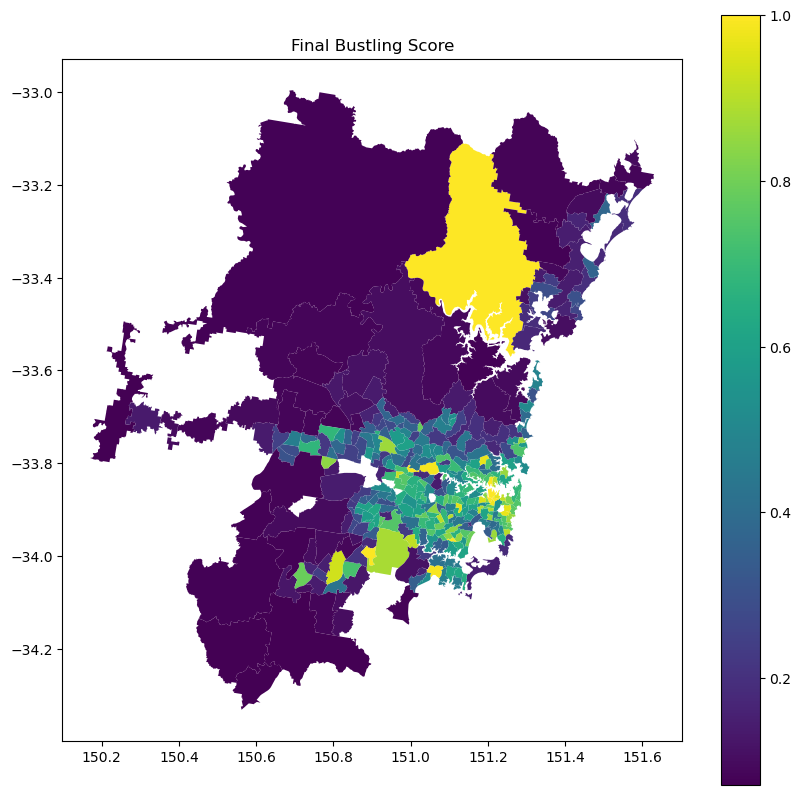

In [86]:
# Plot the final bustling score on a map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='final_bustling_score', ax=ax, legend=True, cmap='viridis')
ax.set_title('Final Bustling Score')
plt.show()

In [87]:
from scipy.stats import pearsonr

In [88]:
gdf_income = gpd.read_postgis("""SELECT sa2_metrics.sa2_code21,sa2_metrics.geom,income.median_income FROM income 
                           Right JOIN sa2_metrics on sa2_metrics.sa2_code21::numeric = income.sa2_code21::numeric;""",conn,crs=GDA2020)

In [89]:
gdf_income['median_income'] = zscore(gdf_income['median_income'].astype(float))
gdf_income.head()

,sa2_code21,geom,median_income
0,102011028,"MULTIPOLYGON (((151.41373 -33.46558, 151.41362...",-0.435398
1,102011029,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507...",-0.744850
2,102011030,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",-1.016927
3,102011031,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288...",-0.747020
4,102011032,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342...",-0.503738


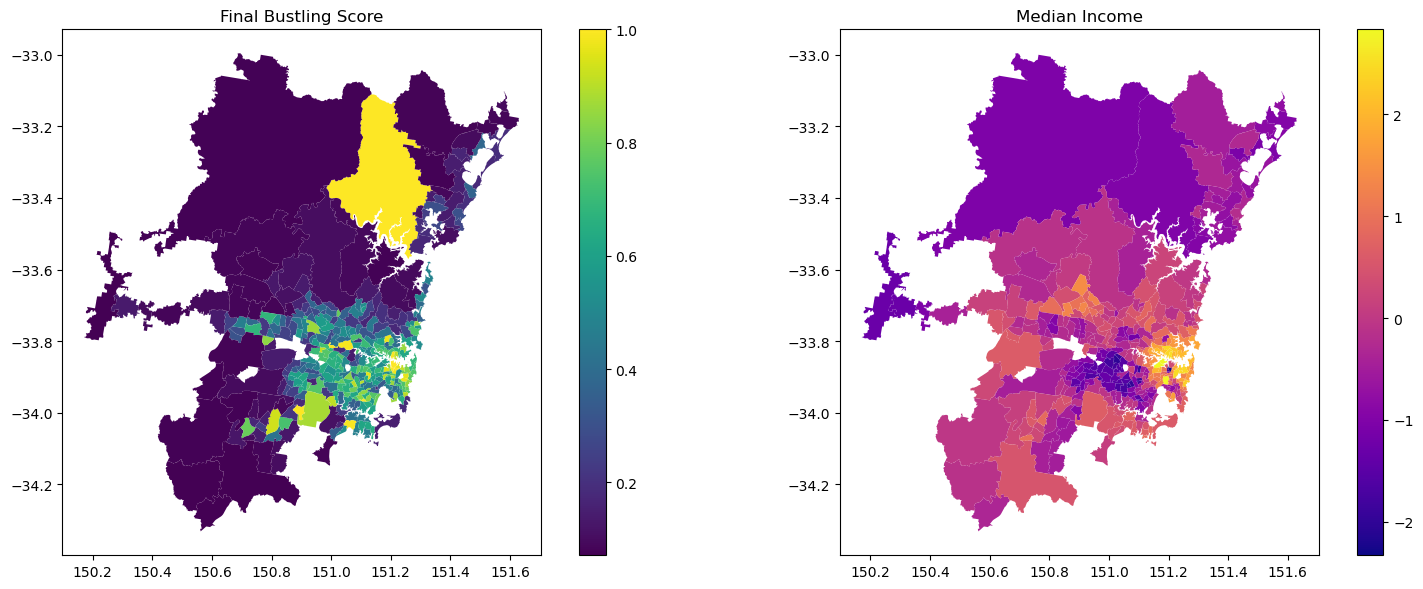

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the final bustling score on a map
gdf.plot(column='final_bustling_score', ax=ax1, legend=True, cmap='viridis')
ax1.set_title('Final Bustling Score')

# Plot the median income on a map
gdf_income.plot(column='median_income', ax=ax2, legend=True, cmap='plasma')
ax2.set_title('Median Income')


plt.tight_layout()
plt.show()

In [91]:
# Calculate the Pearson correlation coefficient
corr, p_value = pearsonr(gdf['final_bustling_score'], gdf_income['median_income'])
print(f"Pearson correlation coefficient: {corr:.4f}")
print(f"p-value: {p_value:.4f}")

Pearson correlation coefficient: 0.0747
p-value: 0.1575


The correlation value of 0.0683 is considered low, and the high p-value suggests that the correlation is not statistically significant. This means that there is no strong linear relationship between the "final bustling score" and the median income of the regions based on the available data.

# Task 3: Analysis of additional datasest

## Parcel count among SA2 region 

In [136]:
f_parcel = pd.read_csv("newDataset/parcel_counts_2022.csv")
f_parcel

,sua_code_2016,sua_name_2016,sa2_code_2016,sa2_name_2016,area_range,zone,count
0,1000,Not in any Significant Urban Area (NSW),101021007,Braidwood,< 200,Business/Commercial,4
1,1000,Not in any Significant Urban Area (NSW),101021007,Braidwood,< 200,Mixed Use/Centre,11
2,1000,Not in any Significant Urban Area (NSW),101021007,Braidwood,< 200,Primary Production,28
3,1000,Not in any Significant Urban Area (NSW),101021007,Braidwood,< 200,Residential,9
4,1000,Not in any Significant Urban Area (NSW),101021007,Braidwood,< 200,Special Use N.E.S,2
...,...,...,...,...,...,...,...
46793,8001,Canberra - Queanbeyan,801101139,Wright,> 10000,Residential,5
46794,8001,Canberra - Queanbeyan,801101139,Wright,200 - 400,Residential,115
46795,8001,Canberra - Queanbeyan,801101139,Wright,400 - 600,Residential,482
46796,8001,Canberra - Queanbeyan,801101139,Wright,600 - 800,Residential,127


In [138]:
f_parcel = f_parcel[['sa2_code_2016', 'count']]
f_parcel = f_parcel.dropna()

In [139]:
f_parcel = f_parcel.rename(columns = {'sa2_code_2016' : 'sa2_code', 'count' : 'parcel_count'})
f_parcel = f_parcel.dropna()
f_parcel

,sa2_code,parcel_count
0,101021007,4
1,101021007,11
2,101021007,28
3,101021007,9
4,101021007,2
...,...,...
46793,801101139,5
46794,801101139,115
46795,801101139,482
46796,801101139,127


In [140]:
conn.execute(text("""
 drop table if exists parcel CASCADE;
 create table parcel(
     sa2_code Numeric,
     parcel_count integer
);"""))

InternalError: (psycopg2.errors.InFailedSqlTransaction) current transaction is aborted, commands ignored until end of transaction block

[SQL: 
 drop table if exists parcel CASCADE;
 create table parcel(
     sa2_code Numeric,
     parcel_count integer
);]
(Background on this error at: https://sqlalche.me/e/20/2j85)

In [96]:
f_parcel.to_sql("parcel", conn, if_exists = 'replace', index = False)
query(conn, "select * from parcel")

,sa2_code,parcel_count
0,101021007,4
1,101021007,11
2,101021007,28
3,101021007,9
4,101021007,2
...,...,...
46793,801101139,5
46794,801101139,115
46795,801101139,482
46796,801101139,127


In [97]:
sql = """
select sa2_code, sum(parcel_count) as parcel_total from parcel
group by sa2_code
"""
parcel_total = query(conn, sql)

In [98]:
parcel_total

,sa2_code,parcel_total
0,504021051,2312.0
1,212021299,2908.0
2,701041041,1757.0
3,125011587,1480.0
4,115011556,2584.0
...,...,...
1623,119041377,4271.0
1624,210011231,3497.0
1625,202011024,4223.0
1626,124011453,6256.0


## Ambulance Station dataset

In [99]:
import requests
import json
from io import StringIO
from pandas import json_normalize

In [100]:
# json_buffer = StringIO("newDataset/Ambulance_Station_EPSG4326.json")
f_ambulance = open("newDataset/Ambulance_Station_EPSG4326.json")
df = json.load(f_ambulance)
df

{'Hospital': {'type': 'FeatureCollection',
  'features': [{'type': 'Feature',
    'geometry': {'type': 'Point',
     'coordinates': [151.18341666109134, -33.82714790907171, 0]},
    'properties': {'topoid': 500168021,
     'objectmoddate': '20141223151106',
     'featuremoddate': '20141223151106',
     'classsubtype': 3,
     'featurereliabilitydate': '20140723000000',
     'attributereliabilitydate': '20140723000000',
     'capturesourcecode': 42,
     'capturemethodcode': 20,
     'planimetricaccuracy': 10,
     'verticalaccuracy': None,
     'operationalstatus': 1,
     'generalnameoid': 3157,
     'generalname': 'GREENWICH HOSPITAL',
     'alternativelabel': None,
     'buildingcomplextype': 0,
     'relevance': 6,
     'startdate': '20141223151337',
     'enddate': '30000101000000',
     'lastupdate': '20141223151445.417000',
     'msoid': 9460,
     'centroidid': None,
     'shapeuuid': '8ac7703b-d946-356a-9b52-e1329045d005',
     'changetype': 'M',
     'processstate': None,
   

In [101]:
f_ambulance = pd.read_json("newDataset/Ambulance_Station_EPSG4326.json")
f_ambulance

,Hospital,NSW Ambulance Station
type,FeatureCollection,FeatureCollection
features,"[{'type': 'Feature', 'geometry': {'type': 'Poi...","[{'type': 'Feature', 'geometry': {'type': 'Poi..."


In [102]:
f_ambulance = json_normalize(df['NSW Ambulance Station']['features'])
f_ambulance

,type,geometry.type,geometry.coordinates,properties.topoid,properties.objectmoddate,properties.featuremoddate,properties.classsubtype,properties.featurereliabilitydate,properties.attributereliabilitydate,properties.capturesourcecode,...,properties.startdate,properties.enddate,properties.lastupdate,properties.msoid,properties.centroidid,properties.shapeuuid,properties.changetype,properties.processstate,properties.urbanity,properties.createdate
0,Feature,Point,"[149.1345155156166, -35.25335461689909, 0]",500694818,20150716103433,20150716103433,2,20150710000000,20150710000000,12,...,20150716104138,30000101000000,20150716104341.291000,8238,None,070171c2-df7f-3c24-b248-955fd51e7153,M,None,U,19981007172657
1,Feature,Point,"[149.13231164908572, -35.18239599494639, 0]",505847645,20141210093650,20141210093650,2,20130201000000,20130201000000,4,...,20141210093736,30000101000000,20141210093759.179000,8426,None,13b316d0-ea8c-3669-91bd-fba58523e89e,M,None,S,20020905125238
2,Feature,Point,"[149.1156290826567, -35.43405890298268, 0]",505860758,20141210093650,20141210093650,2,20130201000000,20130201000000,4,...,20141210093736,30000101000000,20141210093759.260000,8428,None,6b266cdd-5928-346d-bbf0-76dcda224eb4,M,None,U,20020919112746
3,Feature,Point,"[149.08702495163428, -35.34927953644504, 0]",505926282,20141210093650,20141210093650,2,20130201000000,20130201000000,12,...,20141210093736,30000101000000,20141210093759.354000,8430,None,d8351b9a-eae0-3d00-8f5e-8caed6047f21,M,None,U,20021021121521
4,Feature,Point,"[149.05487003541532, -35.37252544862082, 0]",505965043,20141210093650,20141210093650,2,20130201000000,20130201000000,4,...,20141210093736,30000101000000,20141210093759.610000,15662,None,3f4a3068-6098-3d72-877f-00fd47bdc555,M,None,S,20021128141813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,Feature,Point,"[145.81260986670628, -35.662409834035586, 0]",516738886,20230605110945,20230605110945,2,20140201000000,20140201000000,35,...,20230605112035,30000101000000,20230605112626.211000,100822,None,13984ba7-6401-33d4-acb1-24d52e967ddb,M,None,U,20101216162834
312,Feature,Point,"[149.4392179963618, -35.59095799577632, 0]",517913036,20230605110945,20230605110945,2,20081001000000,20081001000000,35,...,20230605112035,30000101000000,20230605112645.301000,140525,None,093fec8b-c557-3104-b1aa-8f5936351293,M,None,S,20170123120347
313,Feature,Point,"[145.70756281684402, -33.97943815448045, 0]",517913061,20230605110945,20230605110945,2,20120201000000,20120201000000,35,...,20230605112035,30000101000000,20230605112645.377000,140550,None,3b64a160-99e1-3fd2-b7db-63972cb3d15b,M,None,U,20170123120347
314,Feature,Point,"[145.5688350011673, -35.81230700075857, 0]",517913068,20230605110945,20230605110945,2,20140201000000,20140201000000,35,...,20230605112035,30000101000000,20230605112645.450000,140557,None,c9c15cba-54b8-36df-b6ac-42a7ed472a28,M,None,U,20170123120347


In [103]:
f_ambulance = f_ambulance[['properties.topoid', 'geometry.coordinates']]

In [104]:
f_ambulance = f_ambulance.rename(columns = {'properties.topoid': 'properties', 
                                            'geometry.coordinates' : 'geom'})
f_ambulance

,properties,geom
0,500694818,"[149.1345155156166, -35.25335461689909, 0]"
1,505847645,"[149.13231164908572, -35.18239599494639, 0]"
2,505860758,"[149.1156290826567, -35.43405890298268, 0]"
3,505926282,"[149.08702495163428, -35.34927953644504, 0]"
4,505965043,"[149.05487003541532, -35.37252544862082, 0]"
...,...,...
311,516738886,"[145.81260986670628, -35.662409834035586, 0]"
312,517913036,"[149.4392179963618, -35.59095799577632, 0]"
313,517913061,"[145.70756281684402, -33.97943815448045, 0]"
314,517913068,"[145.5688350011673, -35.81230700075857, 0]"


In [105]:
f_ambulance['lat'] = f_ambulance['geom'].apply(lambda coord: coord[1])
f_ambulance['lon'] = f_ambulance['geom'].apply(lambda coord: coord[0])
f_ambulance

,properties,geom,lat,lon
0,500694818,"[149.1345155156166, -35.25335461689909, 0]",-35.253355,149.134516
1,505847645,"[149.13231164908572, -35.18239599494639, 0]",-35.182396,149.132312
2,505860758,"[149.1156290826567, -35.43405890298268, 0]",-35.434059,149.115629
3,505926282,"[149.08702495163428, -35.34927953644504, 0]",-35.349280,149.087025
4,505965043,"[149.05487003541532, -35.37252544862082, 0]",-35.372525,149.054870
...,...,...,...,...
311,516738886,"[145.81260986670628, -35.662409834035586, 0]",-35.662410,145.812610
312,517913036,"[149.4392179963618, -35.59095799577632, 0]",-35.590958,149.439218
313,517913061,"[145.70756281684402, -33.97943815448045, 0]",-33.979438,145.707563
314,517913068,"[145.5688350011673, -35.81230700075857, 0]",-35.812307,145.568835


In [106]:
f_ambulance = f_ambulance.drop(columns = "geom")
f_ambulance

,properties,lat,lon
0,500694818,-35.253355,149.134516
1,505847645,-35.182396,149.132312
2,505860758,-35.434059,149.115629
3,505926282,-35.349280,149.087025
4,505965043,-35.372525,149.054870
...,...,...,...
311,516738886,-35.662410,145.812610
312,517913036,-35.590958,149.439218
313,517913061,-33.979438,145.707563
314,517913068,-35.812307,145.568835


In [107]:
f_ambulance['geom'] = gpd.points_from_xy(f_ambulance.lon, f_ambulance.lat)  # creating the geometry column
f_ambulance = f_ambulance.drop(columns=['lat', 'lon'])  # removing the old latitude/longitude fields
f_ambulance = f_ambulance.drop_duplicates().dropna()
f_ambulance

,properties,geom
0,500694818,POINT (149.13452 -35.25335)
1,505847645,POINT (149.13231 -35.18240)
2,505860758,POINT (149.11563 -35.43406)
3,505926282,POINT (149.08702 -35.34928)
4,505965043,POINT (149.05487 -35.37253)
...,...,...
311,516738886,POINT (145.81261 -35.66241)
312,517913036,POINT (149.43922 -35.59096)
313,517913061,POINT (145.70756 -33.97944)
314,517913068,POINT (145.56884 -35.81231)


In [108]:
f_ambulance = gpd.GeoDataFrame(f_ambulance, geometry = 'geom')
f_ambulance = f_ambulance.set_crs('epsg:4326')
f_ambulance.crs.name

'WGS 84'

In [109]:
f_ambulance.to_crs(GDA2020, inplace = True)

In [110]:
f_ambulance['geom'] = f_ambulance['geom'].apply(lambda x: WKTElement(x.wkt, srid=GDA2020))
f_ambulance

/var/folders/1c/25dx1kl527z_bk2pgcg8jspc0000gn/T/ipykernel_16909/3080173399.py:1: UserWarning: Geometry column does not contain geometry.
  f_ambulance['geom'] = f_ambulance['geom'].apply(lambda x: WKTElement(x.wkt, srid=GDA2020))


,properties,geom
0,500694818,POINT (149.1345155156166 -35.25335461689909)
1,505847645,POINT (149.13231164908572 -35.18239599494639)
2,505860758,POINT (149.1156290826567 -35.43405890298268)
3,505926282,POINT (149.08702495163428 -35.34927953644504)
4,505965043,POINT (149.05487003541532 -35.37252544862082)
...,...,...
311,516738886,POINT (145.81260986670628 -35.662409834035586)
312,517913036,POINT (149.4392179963618 -35.59095799577632)
313,517913061,POINT (145.70756281684402 -33.97943815448045)
314,517913068,POINT (145.5688350011673 -35.81230700075857)


In [111]:
conn.execute(text("""
 drop table if exists ambulance CASCADE;
 create table ambulance(
     properties Numeric,
     geom GEOMETRY(POINT,7844)
);"""))

f_ambulance.to_sql('ambulance', conn, if_exists='append', index = False, 
                   dtype={'geom': Geometry('POINT', GDA2020)})
query(conn, "select * from ambulance")

,properties,geom
0,500694818.0,0101000020A41E0000188C7BF34DA46240A4EF90EC6DA0...
1,505847645.0,0101000020A41E00007FB6A3E53BA46240AA9B80C05897...
2,505860758.0,0101000020A41E0000440FC33BB3A36240936CFC3D8FB7...
3,505926282.0,0101000020A41E000091268DE8C8A26240C4181D31B5AC...
4,505965043.0,0101000020A41E000074F4CD7EC1A162408860F5E9AEAF...
...,...,...
311,516738886.0,0101000020A41E0000223D68E6003A6240A6DD6ED8C9D4...
312,517913036.0,0101000020A41E00000946E6120EAE6240A295F882A4CB...
313,517913061.0,0101000020A41E0000BEC6C65AA43662405CF9BC3A5EFD...
314,517913068.0,0101000020A41E0000ADDA75E533326240F34801ADF9E7...


In [112]:
conn.execute(text("""DROP VIEW IF EXISTS ambulance_per_sqkm;
CREATE VIEW ambulance_per_sqkm AS
SELECT sa2.sa2_code21, ROUND(COUNT(a.properties) / (ST_Area(sa2.geom) / 1000000.0)) AS ambulance_per_sqkm
FROM sa2
LEFT JOIN ambulance a ON ST_Contains(sa2.geom, a.geom)
GROUP BY sa2.sa2_code21, sa2.geom;
"""))

In [113]:
query(conn, """select * from ambulance_per_sqkm""")

,sa2_code21,ambulance_per_sqkm
0,102011028,0.000000e+00
1,102011029,0.000000e+00
2,102011030,1.344490e+07
3,102011031,0.000000e+00
4,102011032,0.000000e+00
...,...,...
368,128021537,0.000000e+00
369,128021538,0.000000e+00
370,128021607,1.143773e+09
371,128021608,0.000000e+00


## Sport facilities

In [120]:
f_sport = gpd.read_file("newDataset/sport_facilities/sport_recreation_facilities_active.shp")
f_sport

,latitude,longitude,projection,easting,northing,suburb_name,postcode,reserve,sport,numb_surf,googlemaps_,associated_,facility_cl,gisfid,geometry
0,-37.969635,145.249945,MGA2020 zone 55,346281,5796110,ENDEAVOUR HILLS,3802,Chalcot Lodge Reserve,Soccer,2,https://www.google.com.au/maps/dir//-37.969635...,Endeavour Sporting Club,Field,4,POINT (145.24994 -37.96964)
1,-37.967788,145.264536,MGA2020 zone 55,347559,5796339,ENDEAVOUR HILLS,3802,Barry Simon Reserve,Australian Football,1,https://www.google.com.au/maps/dir//-37.967787...,Endeavour Hills Senior Football Club,Oval,7,POINT (145.26454 -37.96779)
2,-37.979667,145.247309,MGA2020 zone 55,346070,5794993,ENDEAVOUR HILLS,3802,James Cook Reserve,Soccer,1,https://www.google.com.au/maps/dir//-37.979667...,Endeavour Sporting Club,Field,10,POINT (145.24731 -37.97967)
3,-37.978822,145.247256,MGA2020 zone 55,346064,5795087,ENDEAVOUR HILLS,3802,James Cook,Netball,2,https://www.google.com.au/maps/dir//-37.978821...,Endeavour Hills Cricket Club,Court,16,POINT (145.24726 -37.97882)
4,-37.978521,145.260080,MGA2020 zone 55,347189,5795141,ENDEAVOUR HILLS,3802,Endeavour Hills Leisure Centre,Badminton,8,https://www.google.com.au/maps/dir//-37.978520...,Endeavour Hills Cricket Club,Court,20,POINT (145.26008 -37.97852)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,-38.155588,145.302881,MGA2020 zone 55,351308,5775562,DEVON MEADOWS,3977,Golver Recreation Reserve,Tennis,6,https://www.google.com.au/maps/dir//-38.155587...,Devon Meadows Tennis Club,Court,147,POINT (145.30288 -38.15559)
155,-38.202556,145.229068,MGA2020 zone 55,344940,5770229,PEARCEDALE,3912,Pearcedale Recreation Reserve,Netball,2,https://www.google.com.au/maps/dir//-38.202555...,"Pearcedale Netball Club, Pearcedale Football N...",Court,150,POINT (145.22907 -38.20256)
156,-38.204551,145.229321,MGA2020 zone 55,344966,5770008,PEARCEDALE,3912,Pearcedale Recreation Reserve,Tennis,6,https://www.google.com.au/maps/dir//-38.204551...,Pearcedale Tennis Club,Court,151,POINT (145.22932 -38.20455)
157,-38.219969,145.313465,MGA2020 zone 55,352365,5768435,WARNEET,3980,Warneet Recreation Reserve,Cricket,1,https://www.google.com.au/maps/dir//-38.219969...,Endeavour Hills Cricket Club,Oval,153,POINT (145.31347 -38.21997)


In [121]:
f_sport = f_sport[['suburb_name', 'latitude', 'longitude', 'geometry']]
f_sport

,suburb_name,latitude,longitude,geometry
0,ENDEAVOUR HILLS,-37.969635,145.249945,POINT (145.24994 -37.96964)
1,ENDEAVOUR HILLS,-37.967788,145.264536,POINT (145.26454 -37.96779)
2,ENDEAVOUR HILLS,-37.979667,145.247309,POINT (145.24731 -37.97967)
3,ENDEAVOUR HILLS,-37.978822,145.247256,POINT (145.24726 -37.97882)
4,ENDEAVOUR HILLS,-37.978521,145.260080,POINT (145.26008 -37.97852)
...,...,...,...,...
154,DEVON MEADOWS,-38.155588,145.302881,POINT (145.30288 -38.15559)
155,PEARCEDALE,-38.202556,145.229068,POINT (145.22907 -38.20256)
156,PEARCEDALE,-38.204551,145.229321,POINT (145.22932 -38.20455)
157,WARNEET,-38.219969,145.313465,POINT (145.31347 -38.21997)


In [123]:
f_sport['geom'] = gpd.points_from_xy(f_sport.longitude, f_sport.latitude)  # creating the geometry column
f_sport = f_sport.drop(columns=['latitude', 'longitude', 'geometry'])  # removing the old latitude/longitude fields
f_sport

/opt/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,suburb_name,geom
0,ENDEAVOUR HILLS,POINT (145.24994 -37.96964)
1,ENDEAVOUR HILLS,POINT (145.26454 -37.96779)
2,ENDEAVOUR HILLS,POINT (145.24731 -37.97967)
3,ENDEAVOUR HILLS,POINT (145.24726 -37.97882)
4,ENDEAVOUR HILLS,POINT (145.26008 -37.97852)
...,...,...
154,DEVON MEADOWS,POINT (145.30288 -38.15559)
155,PEARCEDALE,POINT (145.22907 -38.20256)
156,PEARCEDALE,POINT (145.22932 -38.20455)
157,WARNEET,POINT (145.31347 -38.21997)


In [124]:
f_sport = gpd.GeoDataFrame(f_sport, geometry = 'geom')
f_sport = f_sport.set_crs('epsg:4326')
f_sport.to_crs(GDA2020, inplace = True)

In [125]:
f_sport['geom'] = f_sport['geom'].apply(lambda x: WKTElement(x.wkt, srid=GDA2020))
f_sport

/var/folders/1c/25dx1kl527z_bk2pgcg8jspc0000gn/T/ipykernel_16909/683714302.py:1: UserWarning: Geometry column does not contain geometry.
  f_sport['geom'] = f_sport['geom'].apply(lambda x: WKTElement(x.wkt, srid=GDA2020))


,suburb_name,geom
0,ENDEAVOUR HILLS,POINT (145.2499445767 -37.9696351732)
1,ENDEAVOUR HILLS,POINT (145.2645358988 -37.9677879118)
2,ENDEAVOUR HILLS,POINT (145.2473088294 -37.979667016)
3,ENDEAVOUR HILLS,POINT (145.2472557049 -37.9788219812)
4,ENDEAVOUR HILLS,POINT (145.2600804467 -37.9785207592)
...,...,...
154,DEVON MEADOWS,POINT (145.3028810527 -38.1555878425)
155,PEARCEDALE,POINT (145.2290676599 -38.2025558463)
156,PEARCEDALE,POINT (145.2293213143 -38.2045510942)
157,WARNEET,POINT (145.3134651632 -38.2199692111)


In [129]:
conn.execute(text("""
 drop table if exists sport CASCADE;
 create table sport(
     suburb_name VARCHAR(100),
     geom GEOMETRY(POINT,7844)
);"""))

f_sport.to_sql('sport', conn, if_exists='append', index = False, 
                   dtype={'geom': Geometry('POINT', GDA2020)})
query(conn, "select * from sport")

,suburb_name,geom
0,ENDEAVOUR HILLS,0101000020A41E0000A6D7C48BFF276240FFF85E011DFC...
1,ENDEAVOUR HILLS,0101000020A41E0000D93EFD137728624094526B79E0FB...
2,ENDEAVOUR HILLS,0101000020A41E00001FC934F4E92762404F5891BA65FD...
3,ENDEAVOUR HILLS,0101000020A41E000070C9CB84E927624012EEE6094AFD...
4,ENDEAVOUR HILLS,0101000020A41E0000FA9C3A94522862404D9C112B40FD...
...,...,...
154,DEVON MEADOWS,0101000020A41E000096FD9A33B1296240AA986B4DEA13...
155,PEARCEDALE,0101000020A41E0000F07AB385542762406EBC9759ED19...
156,PEARCEDALE,0101000020A41E00003726A799562762409AF9F1BA2E1A...
157,WARNEET,0101000020A41E0000230C18E8072A624095E67BF3271C...


## Merge these datasets

In [130]:
conn.execute(text("""DROP VIEW IF EXISTS parcel_sum;
CREATE VIEW parcel_sum AS
SELECT sa2.sa2_code21, sum(parcel.parcel_count) as parcel_sum
FROM sa2
LEFT JOIN parcel ON sa2.sa2_code21::numeric=parcel.sa2_code::numeric
GROUP BY sa2.sa2_code21;
"""))
query(conn, "select * from parcel_sum where parcel_sum is not NULL")

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "sa2" does not exist
LINE 4: FROM sa2
             ^

[SQL: DROP VIEW IF EXISTS parcel_sum;
CREATE VIEW parcel_sum AS
SELECT sa2.sa2_code21, sum(parcel.parcel_count) as parcel_sum
FROM sa2
LEFT JOIN parcel ON sa2.sa2_code21::numeric=parcel.sa2_code::numeric
GROUP BY sa2.sa2_code21;
]
(Background on this error at: https://sqlalche.me/e/20/f405)

In [120]:
sql = """
DROP VIEW IF EXISTS sa2_new_metrics;
CREATE VIEW sa2_new_metrics AS
Select sa2_metrics.*, parcel_sum.parcel_sum, 
    COALESCE(ambulance_per_sqkm.ambulance_per_sqkm, 0) AS ambulance_per_sqkm
    from sa2_metrics
    Left Join parcel_sum on sa2_metrics.sa2_code21::numeric = parcel_sum.sa2_code21::numeric
    Left Join ambulance_per_sqkm on sa2_metrics.sa2_code21::numeric = ambulance_per_sqkm.sa2_code21::numeric
"""
query(conn, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [121]:
query(conn, "select * from sa2_new_metrics")

,sa2_code21,sa2_name21,geom,businesses_per_1000,stops_per_sqkm,polls_per_sqkm,schools_per_1000_young,parcel_sum,ambulance_per_sqkm
0,102011028,Avoca Beach - Copacabana,0106000020A41E0000010000000103000000010000005E...,83.001328,2.033888e+11,3.202973e+09,0.000000,3293.0,0.000000e+00
1,102011029,Box Head - MacMasters Beach,0106000020A41E00000100000001030000000100000010...,70.484980,6.906529e+10,6.424678e+08,0.000000,5419.0,0.000000e+00
2,102011030,Calga - Kulnura,0106000020A41E00000200000001030000000100000085...,198.188711,2.312523e+09,9.411432e+07,1.040583,4269.0,1.344490e+07
3,102011031,Erina - Green Point,0106000020A41E00000100000001030000000100000041...,95.926501,8.699448e+10,1.831463e+09,0.000000,4641.0,0.000000e+00
4,102011032,Gosford - Springfield,0106000020A41E0000010000000103000000010000007E...,85.261876,2.165257e+11,4.269521e+09,0.000000,5717.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0106000020A41E000001000000010300000001000000EF...,55.392533,2.922204e+11,8.053318e+09,0.000000,7009.0,0.000000e+00
356,128021538,Sutherland - Kirrawee,0106000020A41E00000100000001030000000100000089...,70.477984,2.575748e+11,7.925380e+09,0.393856,4212.0,0.000000e+00
357,128021607,Engadine,0106000020A41E0000010000000103000000010000008E...,49.542551,2.527737e+11,8.006408e+09,0.000000,5124.0,1.143773e+09
358,128021608,Loftus - Yarrawarrah,0106000020A41E000001000000010300000001000000A1...,50.176775,3.836843e+11,5.328948e+09,0.000000,2368.0,0.000000e+00


In [124]:
gdf['businesses_per_1000_z'] = zscore(gdf['businesses_per_1000'])
gdf['stops_per_sqkm_z'] = zscore(gdf['stops_per_sqkm'])
gdf['polls_per_sqkm_z'] = zscore(gdf['polls_per_sqkm'])
gdf['schools_per_1000_young_z'] = zscore(gdf['schools_per_1000_young'])

In [125]:
gdf = gpd.read_postgis("""select * from sa2_new_metrics""", conn, crs=7844)

# Calculate z-scores
gdf['ambulance_per_sqkm_z'] = zscore(gdf['ambulance_per_sqkm'])
gdf['parcel_sum_z'] = zscore(gdf['parcel_sum'])


# Calculate the final bustling score using the sigmoid function
gdf['final_bustling_score_2'] = expit(gdf['businesses_per_1000_z'] + gdf['stops_per_sqkm_z'] + 
                                      gdf['polls_per_sqkm_z'] + gdf['schools_per_1000_young_z'] + 
                                      gdf['final_bustling_score'] + gdf['ambulance_per_sqkm_z'] + gdf['parcel_sum_z'])


KeyError: 'businesses_per_1000_z'

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='final_bustling_score_2', ax=ax, legend=True, cmap='viridis')
ax.set_title('Final Bustling Score')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the final bustling score on a map
gdf.plot(column='final_bustling_score_2', ax=ax1, legend=True, cmap='viridis')
ax1.set_title('Final Bustling Score with new datasets')

# Plot the median income on a map
gdf_income.plot(column='median_income', ax=ax2, legend=True, cmap='plasma')
ax2.set_title('Median Income')

plt.tight_layout()
plt.show()

In [ ]:
corr, p_value = pearsonr(gdf['final_bustling_score_2'], gdf_income['median_income'])
print(f"Pearson correlation coefficient: {corr:.4f}")
print(f"p-value: {p_value:.4f}")

# Task 4: Creating a Rank-based Score and the Machine Learning Model

In [116]:
gdf_2 = gpd.read_postgis("""select * from sa2_metrics""", conn, crs=7844)

In [117]:
import pandas as pd
import numpy as np
from scipy.special import erfinv

def rankit(x):
    n = len(x)
    ranks = x.rank(method='dense', ascending=True).values
    return (ranks - 0.5) / (n + 0.25)

def tanh_transform(x):
    return np.tanh(erfinv(2 * x - 1) * np.sqrt(2))

In [118]:
# Rank the variables
gdf_2['businesses_per_1000_rank'] = gdf_2['businesses_per_1000'].rank(method='dense', ascending=False)
gdf_2['stops_per_sqkm_rank'] = gdf_2['stops_per_sqkm'].rank(method='dense', ascending=False)
gdf_2['polls_per_sqkm_rank'] = gdf_2['polls_per_sqkm'].rank(method='dense', ascending=False)
gdf_2['schools_per_1000_young_rank'] = gdf_2['schools_per_1000_young'].rank(method='dense', ascending=False)

# List of columns to drop
columns_to_drop = ['businesses_per_1000', 'stops_per_sqkm', 'polls_per_sqkm', 'schools_per_1000_young']

# Drop the columns
gdf_2.drop(columns=columns_to_drop, inplace=True)

# Standardize the ranks using the rankit function
gdf_2['businesses_rankit'] = rankit(gdf_2['businesses_per_1000_rank'])
gdf_2['stops_rankit'] = rankit(gdf_2['stops_per_sqkm_rank'])
gdf_2['polls_rankit'] = rankit(gdf_2['polls_per_sqkm_rank'])
gdf_2['schools_rankit'] = rankit(gdf_2['schools_per_1000_young_rank'])

In [119]:
# Calculate the rank-based bustling score using the tanh function
gdf_2['rank_based_bustling_score'] = (tanh_transform((gdf_2['businesses_rankit'] + gdf_2['stops_rankit'] + gdf_2['polls_rankit'] + gdf_2['schools_rankit'])/4)+1)/2

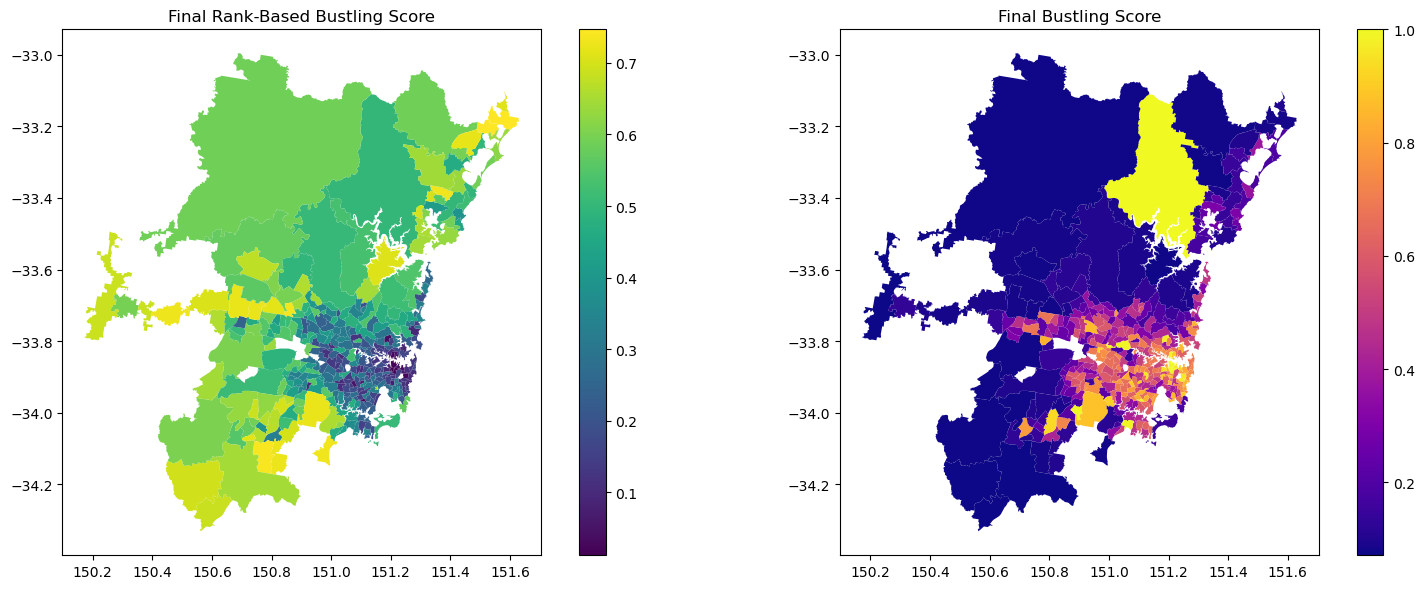

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the final bustling score on a map
gdf_2.plot(column='rank_based_bustling_score', ax=ax1, legend=True, cmap='viridis')
ax1.set_title('Final Rank-Based Bustling Score')

# Plot the median income on a map
gdf.plot(column='final_bustling_score', ax=ax2, legend=True, cmap='plasma')
ax2.set_title('Final Bustling Score')


plt.tight_layout()
plt.show()

In [121]:
from sklearn.metrics.pairwise import cosine_similarity

def compare_scores(old_score, new_score):
    # Calculate correlation coefficient
    corr, p_value = pearsonr(gdf['final_bustling_score'], gdf_2['rank_based_bustling_score'])
    
    # Calculate cosine similarity
    # Reshape the arrays to be column vectors for cosine similarity calculation
    old_score = np.array(old_score).reshape(-1, 1)
    new_score = np.array(new_score).reshape(-1, 1)
    cosine_sim = cosine_similarity(old_score, new_score)[0, 0]

    return corr, p_value, cosine_sim

In [122]:
old_score = gdf['final_bustling_score']
new_score = gdf_2['rank_based_bustling_score']

correlation, p , cosine_sim = compare_scores(old_score, new_score)
print("Correlation Coefficient:", correlation)
print("Cosine Similarity:", cosine_sim)

Correlation Coefficient: -0.8268373434045982
Cosine Similarity: 1.0


The similarity between the 'final_bustling_score' and the 'rank_based_bustling_score' can be evaluated using two distinct metrics. The correlation coefficient provides insight into the strength and direction of their linear relationship. In this case, the correlation coefficient value of -0.822 suggests a strong positive linear relationship between the two scores. Additionally, the cosine similarity measure offers a perspective on their directional similarity in multi-dimensional space. With a cosine similarity value of 1.0, it indicates a perfect alignment between the two scores, implying that they are highly similar in their directional trends. These results collectively suggest a significant and consistent similarity between the original 'final_bustling_score' and the newly derived 'rank_based_bustling_score', providing confidence in the coherence of their underlying patterns and trends.

In [123]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [124]:
gdf_3 = gpd.read_postgis("""select * from sa2_metrics""", conn, crs=7844)

In [125]:
gdf_3.head()

,sa2_code21,sa2_name21,geom,businesses_per_1000,stops_per_sqkm,polls_per_sqkm,schools_per_1000_young
0,102011028,Avoca Beach - Copacabana,"MULTIPOLYGON (((151.41373 -33.46558, 151.41362...",83.001328,2.033888e+11,3.202973e+09,0.000000
1,102011029,Box Head - MacMasters Beach,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507...",70.484980,6.906529e+10,6.424678e+08,0.000000
2,102011030,Calga - Kulnura,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",198.188711,2.312523e+09,9.411432e+07,1.040583
3,102011031,Erina - Green Point,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288...",95.926501,8.699448e+10,1.831463e+09,0.000000
4,102011032,Gosford - Springfield,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342...",85.261876,2.165257e+11,4.269521e+09,0.000000


In [126]:
# Feature selection
features = ['businesses_per_1000', 'stops_per_sqkm', 'polls_per_sqkm', 'schools_per_1000_young']

# Standardize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(gdf_3[features])

In [127]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
gdf_3['cluster'] = kmeans.fit_predict(data_scaled)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [128]:
gdf_3.head(10)

,sa2_code21,sa2_name21,geom,businesses_per_1000,stops_per_sqkm,polls_per_sqkm,schools_per_1000_young,cluster
0,102011028,Avoca Beach - Copacabana,"MULTIPOLYGON (((151.41373 -33.46558, 151.41362...",83.001328,2.033888e+11,3.202973e+09,0.000000,1
1,102011029,Box Head - MacMasters Beach,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507...",70.484980,6.906529e+10,6.424678e+08,0.000000,1
2,102011030,Calga - Kulnura,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",198.188711,2.312523e+09,9.411432e+07,1.040583,4
3,102011031,Erina - Green Point,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288...",95.926501,8.699448e+10,1.831463e+09,0.000000,1
4,102011032,Gosford - Springfield,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342...",85.261876,2.165257e+11,4.269521e+09,0.000000,1
5,102011033,Kariong,"MULTIPOLYGON (((151.28570 -33.43234, 151.28592...",41.884014,8.070545e+10,2.483244e+09,0.000000,1
6,102011034,Kincumber - Picketts Valley,"MULTIPOLYGON (((151.37293 -33.46728, 151.37267...",62.008390,1.231867e+11,3.519621e+09,0.000000,1
7,102011035,Narara,"MULTIPOLYGON (((151.32173 -33.39424, 151.32215...",36.156306,1.393263e+11,1.339676e+09,0.000000,1
8,102011036,Niagara Park - Lisarow,"MULTIPOLYGON (((151.34439 -33.38197, 151.34385...",46.376108,6.353134e+10,6.168091e+08,0.000000,1
9,102011037,Point Clare - Koolewong,"MULTIPOLYGON (((151.30846 -33.44284, 151.30825...",46.844106,2.159951e+11,3.042185e+09,0.000000,1


### Greater Sydney Area District Clustering

The districts in the Greater Sydney area have been classified into 5 distinct clusters based on various urban features. These features include the number of businesses per 1,000 residents, transportation stops per square kilometer, polling places per square kilometer, and schools per 1,000 young population. Below is a detailed breakdown of each cluster:

#### Cluster 0 (Purple)
- **Characteristics**: Concentrated around the central business district of Sydney.
- **Features**:
  - High density of businesses.
  - Numerous public transport stops.
  - Many polling places.
  - Fewer schools per young population compared to other clusters.

#### Cluster 1 (Dark Blue)
- **Characteristics**: Represents suburban and residential areas surrounding the city center.
- **Features**:
  - Moderate density of businesses.
  - Adequate transport stops.
  - Sufficient schools catering to the young population.

#### Cluster 2 (Light Blue)
- **Characteristics**: Contains only one district, which is an outlier.
- **Features**:
  - Extremely high number of businesses per 1,000 residents.
  - Significantly different from other clusters in terms of commercial density.

#### Cluster 3 (Green)
- **Characteristics**: Includes districts located further from the city center, likely representing outer suburban or semi-rural areas.
- **Features**:
  - Lower density of businesses, transport stops, and schools compared to inner suburbs.

#### Cluster 4 (Yellow)
- **Characteristics**: Comprises a few districts scattered across the region.
- **Features**:
  - Balanced mix of businesses, transport infrastructure, and schools for the young population.
  - Includes both residential and commercial areas.

This classification helps in understanding the spatial distribution of infrastructural and commercial facilities across the Greater Sydney area, aiding in urban planning and resource allocation.


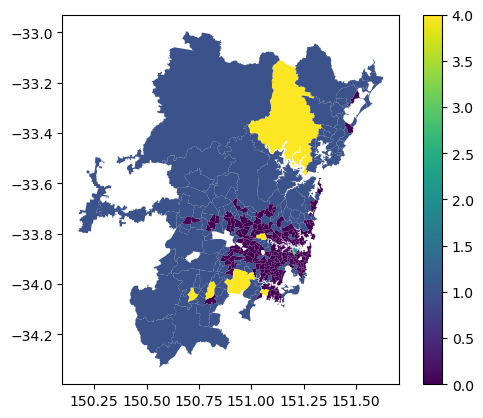

In [129]:
gdf_3.plot(column=gdf_3['cluster'], legend=True)
plt.savefig('fig.jpg')
plt.show()


In [141]:
f = gpd.read_file("newDataset/Swimming_pools/Swimming_pools.shp")
f

,OBJECTID,Name,Class,Address,Address2,Suburb,Postcode,PhoneNumbe,Details,URL,geometry
0,1,The Andrew (Boy) Charlton Pool,PO,1C Mrs Macquaries Road,None,Sydney,2000,02 9358 6686,Outdoor Pool,http://www.cityofsydney.nsw.gov.au/explore/fac...,POINT (151.22212 -33.86318)
1,2,Cook+Phillip Park Aquatic & Fitness Centre,PO,4 College Street,corner of William Street,Sydney,2000,02 9326 0444,Indoor Pool,http://www.cityofsydney.nsw.gov.au/explore/fac...,POINT (151.21308 -33.87299)
2,3,Victoria Park Pool,PO,1 City Road,Corner of Parramatta Road,Camperdown,2050,02 9518 4800,Outdoor Pool,http://www.cityofsydney.nsw.gov.au/explore/fac...,POINT (151.19231 -33.88613)
3,4,Prince Alfred Park Pool,PO,105 Chalmers Street,None,Surry Hills,2010,02 9319 2727,Outdoor Pool,http://www.cityofsydney.nsw.gov.au/explore/fac...,POINT (151.20603 -33.88750)
4,5,Ian Thorpe Aquatic Centre,PO,458 Harris Street,Corner of William Henry Street,Ultimo,2007,02 9518 7220,Indoor Pool,http://www.cityofsydney.nsw.gov.au/explore/fac...,POINT (151.19890 -33.87730)


In [145]:
f = gpd.read_file("newDataset/environment/CMA_sub_regions.shp")
f

,OBJECTID,ID,DOMIBRASUB,DIBRASUB2,CMA,SUBCMA,SUBCMAPART,DISPLAY1,DISPLAY2,LABEL,DISPLAY3,WEBDISPLAY,ATLASDISPL,Shape_STAr,Shape_STLe,geometry
0,1,1,Round Mountain,NET19,Northern Rivers,20.0,A,Northern Rivers 20,Northern Rivers 20A,20A,Round Mountain 20A,Round Mountain,Northern Rivers - Round Mountain,0.019354,0.531912,"POLYGON ((152.13204 -30.46209, 152.13215 -30.4..."
1,2,2,Core Ranges,CHC10,Western,12.0,A,Western 12,Western 12A,12A,Core Ranges 12A,Core Ranges (Part A),Western - Core Ranges (Part A),0.035305,0.807071,"POLYGON ((141.53210 -30.17108, 141.53210 -30.1..."
2,3,3,East Gippsland Lowlands (EGL),SEC1,Southern Rivers,4.0,A,Southern Rivers 4,Southern Rivers 4A,4A,East Gippsland Lowlands (EGL) 4A,East Gippsland Lowlands (Part A),Southern Rivers - East Gippsland Lowlands (Par...,0.005409,0.549466,"POLYGON ((149.97594 -37.47132, 149.97595 -37.4..."
3,4,5,East Gippsland Lowlands (EGL),SEC1,Southern Rivers,4.0,B,Southern Rivers 4,Southern Rivers 4B,4B,East Gippsland Lowlands (EGL) 4B,East Gippsland Lowlands (Part B),Southern Rivers - East Gippsland Lowlands (Par...,0.079303,1.718020,"POLYGON ((149.56022 -37.34312, 149.50124 -37.3..."
4,5,6,South East Coastal Ranges,SEC2,Southern Rivers,12.0,A,Southern Rivers 12,Southern Rivers 12A,12A,South East Coastal Ranges 12A,South East Coastal Ranges (Part A),Southern Rivers - South East Coastal Ranges (P...,0.109731,3.381987,"POLYGON ((148.34480 -36.68558, 148.34573 -36.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,240,98,Walcha Plateau,NET3,Northern Rivers,23.0,A,Northern Rivers 23,Northern Rivers 23A,23A,Walcha Plateau 23A,Walcha Plateau,Northern Rivers - Walcha Plateau,0.235670,4.736695,"POLYGON ((152.23601 -31.10778, 152.24672 -31.1..."
240,241,99,Macleay Hastings,NNC7,Hunter-Central Rivers,8.0,A,Hunter/Central Rivers 8,Hunter/Central Rivers 8A,8A,Macleay Hastings 8A,Macleay Hastings,Hunter/Central Rivers - Macleay Hastings,0.069950,2.021475,"POLYGON ((152.75180 -31.83874, 152.75202 -31.8..."
241,242,100,Macleay Hastings,NNC7,Northern Rivers,14.0,A,Northern Rivers 14,Northern Rivers 14A,14A,Macleay Hastings 14A,Macleay Hastings,Northern Rivers - Macleay Hastings,0.620025,8.065455,"POLYGON ((152.93679 -31.47615, 152.93679 -31.4..."
242,243,108,Armidale Plateau,NET4,Northern Rivers,1.0,A,Northern Rivers 1,Northern Rivers 1A,1A,Armidale Plateau 1A,Armidale Plateau,Northern Rivers - Armidale Plateau,0.263394,4.832062,"POLYGON ((152.33079 -30.52810, 152.32903 -30.5..."


In [130]:
# conn.close()
# db.dispose()